In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from sklearn.metrics import *
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
def load_csvs(csv_paths, columns, dataset="mit", plot=True, rename=None):
    # dataset can be mit or nasa
    data = []
    cycles = []
    # path of directory where files are present
    for i, path in enumerate(csv_paths):
        assert os.path.exists(path)
        df = pd.read_csv(path)
        df = df[columns]
        if dataset == "mit":
            df = df[df['Step_Index'] == 10] # discharge
            df = df[df['Step_Time'] > 0] # remove outliers
            df = df[df['Step_Time'] < 5000] #remove outliers
            df = df[df["Cycle_Index"] > 0] # remove outliers
            #df = df[df["Current"] < -4.0]
            #df["Discharge_Capacity"] = df["Discharge_Capacity"].max()
            df["Discharge_Capacity"] /= 1.1
            df = df[df["Voltage"] <3.22] 
            df = df[df["Voltage"] >2.0]
            
        elif dataset == "nasa":
            if rename:
                df = df.rename(columns=rename)
            df = df[df['Voltage'] > 2.5]
            df = df[df['Voltage'] < 4.]
            df = df[df['Current_measured'] < -1.8]
            df["Voltage"] *= 0.58

            df["Step_Time"] /= 4
            df["Discharge_Capacity"] /= 2.0
        else:
            raise NotImplementedError
        data.append(df)
        cycle = df["Cycle_Index"].unique()
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
        
    if plot:
        plot_cycles(data, cycles)
    
    
    return data, cycles

In [4]:
def fit_spline(data, cycles, no_points=400, dataset="mit"):
    i = 0
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            if dataset =="mit":
                cycle_data = cycle_data[cycle_data.Current < -4.0]
                cycle_data.Discharge_Capacity = cycle_data.Discharge_Capacity.max()
                cycle_data = cycle_data[cycle_data.Voltage > 2.65]
            

            #selecting part of curve that has patterns
            time, voltage, capacity, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.Discharge_Capacity, cycle_data.Cycle_Index
            time = time - time[0]
            if time.shape[0] < 100:
                continue

            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage)

            # creating linear space 0, 4000 of 100,000 points
            xi = np.linspace(0, 1000, 100000)

            #discarding points that are greater than time
            xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
            indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)

            #evaluating voltage for all xi
            yi = ius(xi)

            #selecting voltage at specified indices
            yi = yi[indices]

            #selecting time at specified indices
            xi = xi[indices]
            if dataset == "mit":
                if (yi > 3.3).any() or (yi < 0).any() or (yi[:100] < 3.0).any():
                    print('wrong cycle interpolation, ignore')
                    continue
            ind = np.zeros_like(xi) + ind.values[0]
            capacity = np.zeros_like(xi) + np.max(capacity)
            cell_np.append (np.array([xi, yi, capacity, ind]))
        cell_np = np.concatenate(cell_np, axis=1)
        cell_np = np.transpose (cell_np, (1,0))
        data[i] = pd.DataFrame (cell_np, columns = ['Step_Time', 'Voltage', 'Discharge_Capacity', 'Cycle_Index'])
        i+=1
        
    return data

def plot_cycles(data, cycles):
    for d, cycle in zip(data, cycles):
        for index, c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
           
            plt.xlabel("time")
            plt.ylabel("voltage")
            plt.plot(time,voltage)

    plt.show()
    


In [5]:
def make_data_set(data_set, window, type='train'):
    
    x_data = np.empty((0,2*window),float)
    y_data = []
    for i in range(len(data_set)):
        data = data_set[i]
        cycles = data['Cycle_Index'].unique()
        for cycle in cycles:
            step_time = data[data['Cycle_Index']==cycle].Step_Time.values
            voltage = data[data['Cycle_Index']==cycle].Voltage.values
            dc_capacity = data[data['Cycle_Index']==cycle].Discharge_Capacity.max()

            idx = np.random.randint(0,400-window)
            time_x = step_time[idx:idx+window]
            voltage_x = voltage[idx:idx+window]

            x = np.zeros((1,window*2))
            x[0,::2] = voltage_x
            x[0,1::2] = time_x
            
            x_data = np.concatenate((x_data,x),axis=0)
            y_data.append(dc_capacity)
    
    x_data = x_data.reshape((x_data.shape[0], x_data.shape[1], 1))
    y_data = np.array(y_data)

    univariate = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    if type == 'train':
        univariate = univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    elif type == 'val':
        univariate = univariate.batch(BATCH_SIZE).repeat()
    else:
        univariate = univariate.batch(BATCH_SIZE)

    return x_data, y_data, univariate

In [6]:
# def model_train(input_shape, train, val):
#     lstm_model = tf.keras.models.Sequential([
#         tf.keras.layers.Conv1D(filters=128,kernel_size=5,activation='relu',input_shape=input_shape),
#         tf.keras.layers.MaxPool1D(pool_size=2),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Conv1D(filters=128,kernel_size=5,activation='relu'),
#         tf.keras.layers.MaxPool1D(pool_size=2),
#         tf.keras.layers.Dropout(0.5),
        
#         tf.keras.layers.Conv1D(filters=64,kernel_size=3,activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Conv1D(filters=64,kernel_size=3,activation='relu'),
#         tf.keras.layers.MaxPool1D(pool_size=2),
#         tf.keras.layers.Dropout(0.5),
        
#         tf.keras.layers.LSTM(256),

#         tf.keras.layers.Dense(128),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(64),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(32),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(1)
#     ])

#     lstm_model.compile(optimizer='adam', loss='mse')

#     lstm_model.fit(train, epochs=EPOCHS,
#                    steps_per_epoch=EVALUATION_INTERVAL,
#                    validation_data=val, validation_steps=50)

#     return lstm_model

In [7]:
def model_train(input_shape, train, val):
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(256, input_shape=input_shape),
        tf.keras.layers.Dense(128),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(1)
    ])

    lstm_model.compile(optimizer='adam', loss='mae')

    lstm_model.fit(train, epochs=EPOCHS,
                   steps_per_epoch=EVALUATION_INTERVAL,
                   validation_data=val, validation_steps=50)

    return lstm_model

In [8]:
# def model_train(input_shape, train, val):
#     lstm_model = tf.keras.models.Sequential([
#         tf.keras.layers.Dense(200,activation='relu', input_shape=input_shape),
#         tf.keras.layers.Dense(200,activation='relu'),
#         tf.keras.layers.Dense(200,activation='relu'),
#         tf.keras.layers.Dense(1)
#     ])

#     lstm_model.compile(optimizer='adam', loss='mse')

#     lstm_model.fit(train, epochs=EPOCHS,
#                    steps_per_epoch=EVALUATION_INTERVAL,
#                    validation_data=val, validation_steps=50)

#     return lstm_model

In [27]:
def model_test(model, y_test, test):
    y_pred = model.predict(test)

    plt.figure(figsize=(10, 8))
    plt.plot(y_test, 'k-', label='True')
    plt.plot(y_pred, 'r', label='prediction')
    plt.legend()
    plt.show()
    print(f"Mean Absolute Error : {mean_absolute_error(y_pred, y_test):.6f}")
    print(f"Mean Squared Error(RMSE) : {mean_squared_error(y_pred, y_test, squared=False):.6f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_pred, y_test):.3f}")
    print(f"R2 Score : {r2_score(y_pred, y_test):.3f}")
    


In [10]:
nasa_csvs = glob('./Capacity_data/NASA/*csv')
mit_csvs = glob('./Capacity_data/MIT/*csv')

nasa_columns = ['Time', 'cycle', 'Voltage_measured', 'Current_measured', 'Capacity']
mit_columns = ['Step_Time', 'Step_Index', 'Cycle_Index', 'Current', 'Voltage', 'Discharge_Capacity']
nasa_rename = {'Time': 'Step_Time', 'cycle': 'Cycle_Index', 'Voltage_measured': 'Voltage',
               "Capacity": 'Discharge_Capacity'}
print(f"Total {len(nasa_csvs)} nasa csvs")
print(f"Total {len(mit_csvs)} mit csvs")
for csv in nasa_csvs:
    print(csv)
for csv in mit_csvs:
    print(csv)

Total 5 nasa csvs
Total 10 mit csvs
./Capacity_data/NASA\B0005_discharge.csv
./Capacity_data/NASA\B0006_discharge.csv
./Capacity_data/NASA\B0007_discharge.csv
./Capacity_data/NASA\B0018_discharge.csv
./Capacity_data/NASA\B0036_discharge_corrected.csv
./Capacity_data/MIT\2017-05-12_5_4C-60per_3C_CH16.csv
./Capacity_data/MIT\2017-05-12_5_4C-80per_5_4C_CH12.csv
./Capacity_data/MIT\2017-05-12_6C-40per_3C_CH25.csv
./Capacity_data/MIT\2017-05-12_6C-40per_3C_CH26.csv
./Capacity_data/MIT\2017-05-12_6C-40per_3_6C_CH34.csv
./Capacity_data/MIT\2017-05-12_6C-50per_3_6C_CH36.csv
./Capacity_data/MIT\2017-05-12_8C-25per_3_6C_CH45.csv
./Capacity_data/MIT\2017-06-30_2C-10per_6C_CH10.csv
./Capacity_data/MIT\b1c1corrected.csv
./Capacity_data/MIT\b1c2corrected.csv


total points in ./Capacity_data/NASA\B0005_discharge.csv (45072, 5)
total points in ./Capacity_data/NASA\B0006_discharge.csv (44186, 5)
total points in ./Capacity_data/NASA\B0007_discharge.csv (47798, 5)
total points in ./Capacity_data/NASA\B0018_discharge.csv (31859, 5)
total points in ./Capacity_data/NASA\B0036_discharge_corrected.csv (46164, 5)


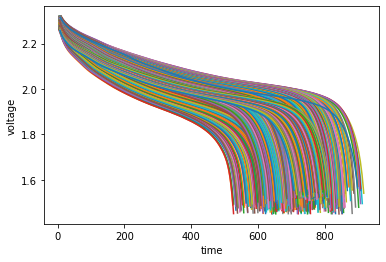

total points in ./Capacity_data/MIT\2017-05-12_5_4C-60per_3C_CH16.csv (242428, 6)
total points in ./Capacity_data/MIT\2017-05-12_5_4C-80per_5_4C_CH12.csv (183283, 6)
total points in ./Capacity_data/MIT\2017-05-12_6C-40per_3C_CH25.csv (335532, 6)
total points in ./Capacity_data/MIT\2017-05-12_6C-40per_3C_CH26.csv (287278, 6)
total points in ./Capacity_data/MIT\2017-05-12_6C-40per_3_6C_CH34.csv (282169, 6)
total points in ./Capacity_data/MIT\2017-05-12_6C-50per_3_6C_CH36.csv (289478, 6)
total points in ./Capacity_data/MIT\2017-05-12_8C-25per_3_6C_CH45.csv (238964, 6)
total points in ./Capacity_data/MIT\2017-06-30_2C-10per_6C_CH10.csv (53837, 6)
total points in ./Capacity_data/MIT\b1c1corrected.csv (725771, 6)
total points in ./Capacity_data/MIT\b1c2corrected.csv (756812, 6)


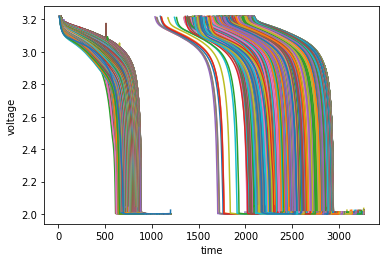

In [11]:
nasa_data, nasa_cycles = load_csvs(nasa_csvs, nasa_columns, dataset="nasa", rename=nasa_rename)
mit_data, mit_cycles = load_csvs(mit_csvs, mit_columns, dataset="mit")

In [12]:
print("Fitting spline on NASA set ...")
nasa_data = fit_spline(nasa_data, nasa_cycles, dataset="nasa")
print("Fitting Split on MIT set ...")
mit_data = fit_spline(mit_data, mit_cycles, dataset="mit")

Fitting spline on NASA set ...
Fitting Split on MIT set ...
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore
wrong cycle interpolation, ignore


In [13]:
window = 25
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 100

In [14]:
x_train, y_train, train_univariate = make_data_set(nasa_data[:3]+mit_data[:4],window=25)
x_val, y_val, val_univariate = make_data_set([nasa_data[3]]+[mit_data[4]],window=25,type='val')

In [15]:
x_test1, y_test1, test_univariate1 = make_data_set([nasa_data[-1]],window=25,type='test')
x_test2, y_test2, test_univariate2 = make_data_set([mit_data[6]],window=25,type='test')

In [20]:
input_shape = x_train.shape[1:]
model = model_train(input_shape, train_univariate, val_univariate)

Epoch 1/100
200/200 [==============================] - 19s 85ms/step - loss: 0.1211 - val_loss: 0.0534
Epoch 2/100
200/200 [==============================] - 17s 87ms/step - loss: 0.0585 - val_loss: 0.0465
Epoch 3/100
200/200 [==============================] - 18s 89ms/step - loss: 0.0524 - val_loss: 0.0780
Epoch 4/100
200/200 [==============================] - 18s 88ms/step - loss: 0.0553 - val_loss: 0.0604
Epoch 5/100
200/200 [==============================] - 17s 83ms/step - loss: 0.0516 - val_loss: 0.0465
Epoch 6/100
200/200 [==============================] - 17s 83ms/step - loss: 0.0521 - val_loss: 0.0460
Epoch 7/100
200/200 [==============================] - 17s 83ms/step - loss: 0.0523 - val_loss: 0.0590
Epoch 8/100
200/200 [==============================] - 17s 83ms/step - loss: 0.0506 - val_loss: 0.0510
Epoch 9/100
200/200 [==============================] - 17s 84ms/step - loss: 0.0500 - val_loss: 0.0438
Epoch 10/100
200/200 [==============================] - 17s 84ms/step - l

Epoch 80/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0082 - val_loss: 0.0107
Epoch 81/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 82/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 83/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 84/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 85/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 86/100
200/200 [==============================] - 17s 86ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 87/100
200/200 [==============================] - 17s 87ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 88/100
200/200 [==============================] - 17s 87ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 89/100
200/200 [==============================] - 17s 86ms

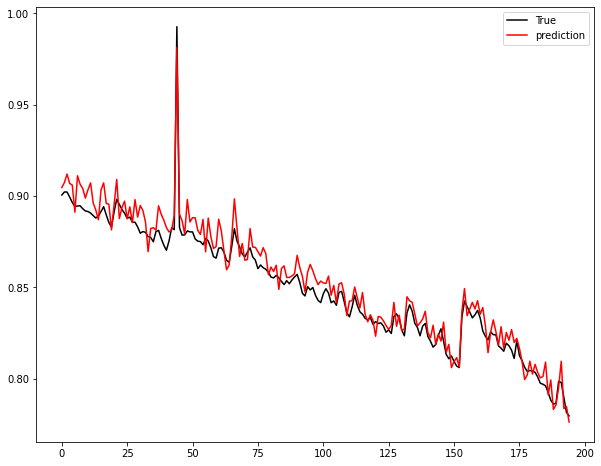

Mean Absolute Error : 0.006069
Mean Squared Error(RMSE) : 0.007324
MAPE: 0.007
R2 Score : 0.953


In [28]:
model_test(model, y_test1, test_univariate1)

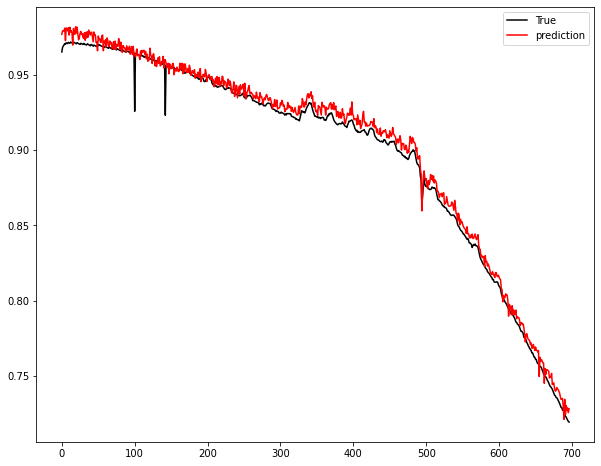

Mean Absolute Error : 0.004753
Mean Squared Error(RMSE) : 0.005672
MAPE: 0.005
R2 Score : 0.993


In [29]:
model_test(model, y_test2, test_univariate2)

In [25]:
NASA= model.predict(test_univariate1)
MIT= model.predict(test_univariate2)

In [26]:
pd.DataFrame(NASA).to_csv(f'./LSTM_NASA_Pred.csv')
pd.DataFrame(MIT).to_csv(f'./LSTM_MIT_Pred.csv')

In [125]:
def make_data_set(data_set, window, type='train'):
    
    x_data = np.empty((0,2*window),float)
    y_data = []
    for i in range(len(data_set)):
        data = data_set[i]
        cycles = data['Cycle_Index'].unique()
        for cycle in cycles:
            step_time = data[data['Cycle_Index']==cycle].Step_Time.values
            voltage = data[data['Cycle_Index']==cycle].Voltage.values
            dc_capacity = data[data['Cycle_Index']==cycle].Discharge_Capacity.max()

            idx = np.random.randint(0,400-window)
            time_x = step_time[idx:idx+window]
            voltage_x = voltage[idx:idx+window]

            x = np.zeros((1,window*2))
            x[0,::2] = voltage_x
            x[0,1::2] = time_x
            
            x_data = np.concatenate((x_data,x),axis=0)
            y_data.append(dc_capacity)
        
    y_data = np.array(y_data)

    univariate = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    if type == 'train':
        univariate = univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    elif type == 'val':
        univariate = univariate.batch(BATCH_SIZE).repeat()
    else:
        univariate = univariate.batch(BATCH_SIZE)

    return x_data, y_data, univariate

In [119]:
x_data,y_data = make_data_set(mit_data[:1],25)

In [124]:
y_data.shape

(847,)

In [120]:
x_data.shape

(847, 50)

In [26]:
cycles = test['Cycle_Index'].unique()

In [29]:
step_time = test[test['Cycle_Index']==cycles[0]].Step_Time.values
voltage = test[test['Cycle_Index']==cycles[0]].Voltage.values
dc_capacity = test[test['Cycle_Index']==cycles[0]].Discharge_Capacity.max()

In [31]:
window=25
idx = np.random.randint(0,400-window)
time_x = step_time[idx:idx+window]
voltage_x = voltage[idx:idx+window]

In [100]:
x_data = np.zeros((1,voltage_x.shape[0]*2))
x_data[0,::2] = voltage_x
x_data[0,1::2] = time_x

In [103]:
x_data.shape

(1, 50)

In [104]:
x_data

array([[  2.9012256 , 760.54760548,   2.89862957, 762.59762598,
          2.89305675, 764.64764648,   2.89098728, 766.69766698,
          2.88663886, 768.74768748,   2.88086259, 770.79770798,
          2.87632993, 772.84772848,   2.87114327, 774.89774898,
          2.86422844, 776.94776948,   2.86097346, 778.99778998,
          2.8538944 , 781.04781048,   2.84943632, 783.09783098,
          2.84127649, 785.14785148,   2.8347307 , 787.19787198,
          2.82966631, 789.24789248,   2.81959307, 791.29791298,
          2.81107457, 793.34793348,   2.80520198, 795.39795398,
          2.79268312, 797.44797448,   2.78606068, 799.49799498,
          2.77468148, 801.54801548,   2.76172808, 803.59803598,
          2.75180985, 805.64805648,   2.73928659, 807.69807698,
          2.72362582, 809.74809748]])

In [39]:
step_time = test[test['Cycle_Index']==cycles[1]].Step_Time.values
voltage = test[test['Cycle_Index']==cycles[1]].Voltage.values
dc_capacity = test[test['Cycle_Index']==cycles[1]].Discharge_Capacity.max()

In [40]:
window=25
idx = np.random.randint(0,400-window)
time_x = step_time[idx:idx+window]
voltage_x = voltage[idx:idx+window]

In [108]:
x_data1 = np.zeros((1,voltage_x.shape[0]*2))
x_data1[:,::2] = voltage_x
x_data1[:,1::2] = time_x

In [97]:
arr = np.empty((0,50),float)

In [113]:
arr = np.concatenate((arr,x_data1),axis=0)

In [115]:
arr.shape

(3, 50)

In [110]:
arr.shape

(2, 50)

In [94]:
x_data.shape

(50,)

In [84]:
arr.shape

(0, 50)

In [89]:
x_data

array([  3.00062258, 664.44664447,   2.99935515, 666.48666487,
         2.99792787, 668.53668537,   2.9964174 , 670.57670577,
         2.99488779, 672.62672627,   2.99343238, 674.66674667,
         2.99210864, 676.71676717,   2.99080069, 678.75678757,
         2.98915181, 680.79680797,   2.98706039, 682.84682847,
         2.98550983, 684.88684887,   2.98479048, 686.93686937,
         2.98262087, 688.97688977,   2.98146275, 691.02691027,
         2.98025737, 693.06693067,   2.97800555, 695.11695117,
         2.97590419, 697.15697157,   2.97422107, 699.19699197,
         2.97264626, 701.24701247,   2.97091077, 703.28703287,
         2.9687736 , 705.33705337,   2.96616019, 707.37707377,
         2.96394309, 709.42709427,   2.96315163, 711.46711467,
         2.96059195, 713.51713517])

In [81]:
arr[0,:] = x_data1

IndexError: index 0 is out of bounds for axis 0 with size 0

In [76]:
x_data1.shape

(50,)

In [79]:
arr = np.empty((0,50))

In [86]:
arr = np.concatenate((arr,x_data1.T),axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [72]:
arr

array([], shape=(0, 3), dtype=float64)

In [70]:
arr.shape

(100,)

In [ ]:
data_list = []
    for i in range(len(data_set)):
        for j in range(len(data_set[i]) // 400):
            data_list.append([data_set[i].iloc[j * 400:(j + 1) * 400, 1], data_set[i].iloc[j * 400, 2]])

    x_data, y_data = [x for x, _ in data_list], [y for _, y in data_list]
    x_data, y_data = np.array(x_data), np.array(y_data)
    x_data = x_data.reshape((x_data.shape[0], x_data.shape[1], 1))

In [9]:
mit_data[0]

,Step_Time,Voltage,Discharge_Capacity,Cycle_Index
0,0.000000,3.214887,0.938784,1.0
1,2.040020,3.210973,0.938784,1.0
2,4.080041,3.207391,0.938784,1.0
3,6.130061,3.204164,0.938784,1.0
4,8.170082,3.201363,0.938784,1.0
...,...,...,...,...
338795,570.965710,2.691555,0.663292,854.0
338796,572.405724,2.681730,0.663292,854.0
338797,573.855739,2.677373,0.663292,854.0
338798,575.295753,2.666758,0.663292,854.0


In [10]:
test = mit_data[0]

In [12]:
cycle = test['Cycle_Index'].unique()

In [21]:
test[test['Cycle_Index']==cycle[1]].Voltage.values[0:25]

array([3.2176399 , 3.20834679, 3.20772849, 3.20744749, 3.20452122,
       3.20069847, 3.19758772, 3.19594409, 3.19505795, 3.19266808,
       3.19161574, 3.18999336, 3.18840362, 3.18788385, 3.18653211,
       3.18517672, 3.18423438, 3.18334725, 3.18223185, 3.18132854,
       3.18099862, 3.18002034, 3.17939902, 3.1787955 , 3.17793503])

In [ ]:
y_data = []
for i in range(len(data_set)):
    data = data_set[i]
    cycles = data['Cycle_Index'].unique()
    for cycle in cycles:
        step_time = data[data['Cycle_Index']==cycle].Step_Time.values
        voltage = data[data['Cycle_Index']==cycle].Voltage.values
        dc_capacity = data[data['Cycle_Index']==cycle].Discharge_Capacity.max()
        
        idx = np.random.randint(0,400-window)
        time_x = step_time[idx:idx+window]
        voltage_x = voltage[idx:idx+window]
        
        x_data = np.zeros((voltage_x.shape[0]*2))
        x[::2] = voltage_x
        x[1::2] = time_x
        
        y_data.append(dc_capacity)
        
        return x_data, np.array(y_data)

In [22]:
for x in cycle:
    print(x)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0
185.0
186

In [133]:
data_set = mit_data

In [134]:
cycles = []

In [135]:
for x in data_set:
    cycles.append(x.Cycle_Index.unique())

In [137]:
spc = [x.shape[0] for x in cycles]

In [138]:
cumsum = np.cumsum(spc)

In [174]:
idx = 1000

In [175]:
cell_no = bisect(cumsum,idx)

In [176]:
cell_no

1

In [177]:
ind = idx if cell_no ==0 else idx-cumsum[cell_no-1]

In [178]:
ind

153

In [179]:
cycles[cell_no][ind]

155.0

In [180]:
cumsum

array([ 847, 1404, 2101, 2937, 3807, 4816])

In [153]:
data_set[cell_no].Cycle_Index

0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
          ...  
338795    854.0
338796    854.0
338797    854.0
338798    854.0
338799    854.0
Name: Cycle_Index, Length: 338800, dtype: float64

In [ ]:
time_step = data_set[cell_no][]

In [105]:
data_set = [mit_data[0]]

In [106]:
data_list = []
for i in range(len(data_set)):
    for j in range(len(data_set[i]) // 400):
        data_list.append([data_set[i].iloc[j * 400:(j + 1) * 400, 1], data_set[i].iloc[j * 400, 2]])

x_data, y_data = [x for x, _ in data_list], [y for _, y in data_list]
x_data, y_data = np.array(x_data), np.array(y_data)
x_data = x_data.reshape((x_data.shape[0], x_data.shape[1], 1))

In [185]:
test.iloc[0:400,:2].values[:25]

array([[ 0.        ,  3.2148867 ],
       [ 2.0400204 ,  3.21097261],
       [ 4.0800408 ,  3.20739068],
       [ 6.1300613 ,  3.20416427],
       [ 8.1700817 ,  3.20136315],
       [10.2201022 ,  3.19899831],
       [12.2601226 ,  3.19702958],
       [14.3101431 ,  3.19507075],
       [16.3501635 ,  3.19279577],
       [18.3901839 ,  3.19076594],
       [20.4402044 ,  3.19007466],
       [22.4802248 ,  3.18910057],
       [24.5302453 ,  3.18748774],
       [26.5702657 ,  3.18610194],
       [28.6202862 ,  3.18499406],
       [30.6603066 ,  3.18384815],
       [32.7103271 ,  3.18266305],
       [34.7503475 ,  3.18202055],
       [36.7903679 ,  3.18168698],
       [38.8403884 ,  3.1807467 ],
       [40.8804088 ,  3.17961739],
       [42.9304293 ,  3.1786782 ],
       [44.9704497 ,  3.17827277],
       [47.0204702 ,  3.17770737],
       [49.0604906 ,  3.17680044]])

In [118]:
window = 25

In [119]:
np.random.randint(0,400-window)

18

In [122]:
cnt = 0
for i in range(0,len(test),400):
    cnt+=1
print(i,cnt)

338400 847


In [123]:
cnt = 0
for i in range(len(test)//400):
    cnt+=1
print(i*400,cnt)

338400 847


In [108]:
x_data.shape

(847, 400, 1)

In [109]:
y_data.shape

(847,)

In [112]:
x_data[0].shape

(400, 1)

In [23]:
data_list = []

In [24]:
for i in range(len(mit_data[0])//400):
    data_list.append([mit_data[0].iloc[i*400:(i+1)*400,0:2],mit_data[0].iloc[i*400,2]])

In [96]:
test = mit_data[0]

In [104]:
test

,Step_Time,Voltage,Discharge_Capacity,Cycle_Index
0,0.000000,3.214887,0.938784,1.0
1,2.040020,3.210973,0.938784,1.0
2,4.080041,3.207391,0.938784,1.0
3,6.130061,3.204164,0.938784,1.0
4,8.170082,3.201363,0.938784,1.0
...,...,...,...,...
338795,570.965710,2.691555,0.663292,854.0
338796,572.405724,2.681730,0.663292,854.0
338797,573.855739,2.677373,0.663292,854.0
338798,575.295753,2.666758,0.663292,854.0


<AxesSubplot:>

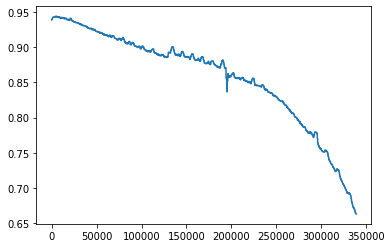

In [98]:
test.iloc[:,2].plot()

In [101]:
len(test.iloc[:,2].unique())

847

In [102]:
len(test.iloc[:,-1].unique())

847

In [103]:
test

,Step_Time,Voltage,Discharge_Capacity,Cycle_Index
0,0.000000,3.214887,0.938784,1.0
1,2.040020,3.210973,0.938784,1.0
2,4.080041,3.207391,0.938784,1.0
3,6.130061,3.204164,0.938784,1.0
4,8.170082,3.201363,0.938784,1.0
...,...,...,...,...
338795,570.965710,2.691555,0.663292,854.0
338796,572.405724,2.681730,0.663292,854.0
338797,573.855739,2.677373,0.663292,854.0
338798,575.295753,2.666758,0.663292,854.0


In [18]:
mit_data[0]

,Step_Time,Voltage,Discharge_Capacity,Cycle_Index
0,0.000000,3.214887,0.938784,1.0
1,2.040020,3.210973,0.938784,1.0
2,4.080041,3.207391,0.938784,1.0
3,6.130061,3.204164,0.938784,1.0
4,8.170082,3.201363,0.938784,1.0
...,...,...,...,...
338795,570.965710,2.691555,0.663292,854.0
338796,572.405724,2.681730,0.663292,854.0
338797,573.855739,2.677373,0.663292,854.0
338798,575.295753,2.666758,0.663292,854.0


In [20]:
len(mit_data[0].Discharge_Capacity.unique())

847

In [22]:
len(mit_data[0].Cycle_Index.unique())

847

In [ ]:
data_list = []
for i in range(len(data_set)):
    for j in range(len(data_set[i]) // 400):
        data_list.append([data_set[i].iloc[j * 400:(j + 1) * 400, 1], data_set[i].iloc[j * 400, 2]])

x_data, y_data = [x for x, _ in data_list], [y for _, y in data_list]
x_data, y_data = np.array(x_data), np.array(y_data)
x_data = x_data.reshape((x_data.shape[0], x_data.shape[1], 1))

In [45]:
data_list = []
for x in range(4):
    for i in range(len(mit_data[x])//400):
        data_list.append([mit_data[x].iloc[i*400:(i+1)*400,1],mit_data[x].iloc[i*400,2]])

In [27]:
x_data,y_data = [[x,y] for x,y in data_list]

ValueError: too many values to unpack (expected 2)

In [34]:
np.array(data_list).T.shape

(2, 847)

In [46]:
np.array(data_list).shape

(2937, 2)

In [47]:
850*4

3400

In [41]:
np.array(data_list)[:,0].shape

(847,)

In [42]:
np.array(data_list).T[0].shape

(847,)

In [43]:
np.array(data_list).T[1].shape

(847,)

In [44]:
mit_data[:4]

[         Step_Time   Voltage  Discharge_Capacity  Cycle_Index
 0         0.000000  3.214887            0.938784          1.0
 1         2.040020  3.210973            0.938784          1.0
 2         4.080041  3.207391            0.938784          1.0
 3         6.130061  3.204164            0.938784          1.0
 4         8.170082  3.201363            0.938784          1.0
 ...            ...       ...                 ...          ...
 338795  570.965710  2.691555            0.663292        854.0
 338796  572.405724  2.681730            0.663292        854.0
 338797  573.855739  2.677373            0.663292        854.0
 338798  575.295753  2.666758            0.663292        854.0
 338799  576.745767  2.658693            0.663292        854.0
 
 [338800 rows x 4 columns],
          Step_Time   Voltage  Discharge_Capacity  Cycle_Index
 0         0.000000  3.219627            0.943559          1.0
 1         2.050021  3.216064            0.943559          1.0
 2         4.110041  3.21

In [70]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from bisect import bisect
  

# procesing data to get samples for training and testing
    
class CapacityDataset(Dataset):
    def __init__(self, data, window=25, type="train", random=False):
        self.cycles = []
        self.random = random
        for d in data:
            self.cycles.append(d.Cycle_Index.unique())
        self.data = data
        self.window = window
        # cycles per cell
        self.spc = [cycle.shape[0] for cycle in  self.cycles]
        
    def __len__(self):
        return sum(self.spc)

    def __getitem__(self, idx):
        
        # the next three lines are locating the index in cycles of a particular cell
        
        cumsum = np.cumsum(self.spc)
        cell_no = bisect(cumsum, idx)
        ind = idx if cell_no == 0 else idx - cumsum[cell_no - 1]
        
        # picking the value of time, voltage, and capacity for the specified cycle during training or testing
        
        time_step = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Step_Time.values
        voltage = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Voltage.values
        capacity = self.data[cell_no][self.data[cell_no].Cycle_Index == self.cycles[cell_no][ind]].Discharge_Capacity.max()
        
        # choosing a segment of specified length from the discharge curve for training or testing
        # if random = True, the segment will start anywhere from start of curve to 400- length of segment
#         print (time_step.shape, voltage.shape, cell_no, ind, capacity )
        start = 0 if not self.random else np.random.randint(0, 400 - self.window)
        time_x = time_step[start: start+self.window]
        voltage_x = voltage[start: start+self.window]
        
        # creating input / feature vector (segment length x2)
        # the vector has voltage values followed by the corresponding time values
        x = np.zeros((voltage_x.shape[0]*2))
        x[::2] = voltage_x
        x[1::2] = time_x/100
#         print (x.shape)
        return x , torch.from_numpy(np.array([capacity]))




In [71]:
train_voltage_c = CapacityDataset(mit_data[1:] ,random=True)
train_loader_c = DataLoader(train_voltage_c, batch_size=64, shuffle=True)
test_voltage_c = CapacityDataset([mit_data[0]], type='test', random=True)
test_loader_c = DataLoader(test_voltage_c, batch_size=64, shuffle=False)

In [82]:
cnt = 0
for x,y in test_loader_c:
    cnt+=1

In [85]:
len(mit_data[0])/400

847.0

In [95]:
64*13

832

In [83]:
cnt

14

In [79]:
f,l = next(iter(test_loader_c))

In [89]:
f.shape

torch.Size([64, 50])

In [92]:
len(mit_data[0]['Cycle_Index'].unique())

847

64

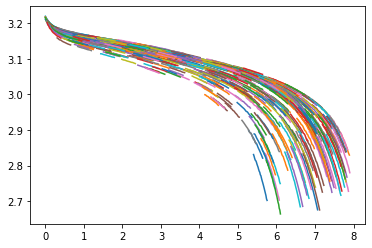

In [72]:
for x, y in test_loader_c: 
    for i,curve in enumerate(x):
        plt.plot(curve[1::2], curve[::2])
plt.show()

In [59]:
for dset,mode in [(train_loader_c,'train'),(test_loader_c,'test')]:
    for idx, (x,y) in enumerate(dset):
        x = x.float()

AttributeError: 'DataFrame' object has no attribute 'Charge_Capacity'